In [2]:
import os 
import shutil
import sys 
import pathlib
import subprocess
import numpy as np
import cv2
import open3d as o3d
import docker
import abc
import evops
import tqdm
import matplotlib.pyplot as plt

from typing import Collection
from docker.types import Mount
from pathlib import Path
from shutil import rmtree
from evops import metrics as evops_metrics

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
class Algorithm(abc.ABC):
    @abc.abstractmethod
    def __init__(self, container_name: str, cfg_path: Path, pcd_path: Path, **kwargs):
        self.container_name = container_name
        self.cfg_path = cfg_path
        self.pcd_path = pcd_path
        self._alg_input_dir = Path("alg_input")
        self._alg_output_dir = Path("output")
        self._alg_artifact_name = None
        self._cfg = None
        self._parameter_list = ()

    @abc.abstractmethod
    def _preprocess_input(self) -> Collection[str]:
        pass

    @abc.abstractmethod
    def _output_to_labels(self, output_path: Path) -> np.ndarray:
        pass

    @abc.abstractmethod
    def _clear_artifacts(self):
        pass

    def _evaluate_algorithm(self, input_parameters: Collection[str]) -> Path:
        client = docker.from_env()
        input_mount = Mount(
            target="/app/build/input",
            source=str(self._alg_input_dir.absolute()),
            type="bind",
        )
        output_mount = Mount(
            target="/app/build/output",
            source=str(self._alg_output_dir.absolute()),
            type="bind",
        )

        client.containers.run(
            self.container_name,
            " ".join(input_parameters),
            mounts=[input_mount, output_mount],
            auto_remove=True
        )

        return self._alg_output_dir / self._alg_artifact_name

    def run(self) -> np.ndarray:

        if self._alg_input_dir.exists():
            rmtree(self._alg_input_dir)
        os.mkdir(self._alg_input_dir)

        parameter_list = self._preprocess_input()

        if os.path.exists(self._alg_output_dir):
            rmtree(self._alg_output_dir)
        os.mkdir(self._alg_output_dir)

        try:
            output_path = self._evaluate_algorithm(parameter_list)
            labels = self._output_to_labels(output_path)
        finally:
            self._clear_artifacts()

        return labels

## PEAC Runner

In [4]:
# class PEAC(Algorithm):
#     def __init__(
#         self,
#         container_name: str,
#         pcd_path: Path,
#         config_path: Path,
#         intrinsics_path: Path,
#         camera_shape: tuple = (480, 640),
#     ):
#         self.container_name = container_name
#         self.cfg_path = config_path
#         self.intrinsics_path = intrinsics_path
#         self.pcd_path = pcd_path
#         self.pcd_name = Path(self.pcd_path).stem
#         self.camera_height = camera_shape[0]
#         self.camera_width = camera_shape[1]
#         self._cfg = None
#         self._alg_input_dir = Path("input")
#         self._alg_output_dir = Path("output")
#         self._alg_artifact_name = Path(self.pcd_name + "/" + self.pcd_name + ".pcd")

#     def _preprocess_input(self) -> Collection[str]:
#         pcd_name = self.__preprocess_point_cloud().name

#         return [pcd_name, self.cfg_path]

#     def _evaluate_algorithm(self, input_parameters: Collection[str]) -> Path:
#         os.mkdir(self._alg_output_dir / self.pcd_name)
#         return super()._evaluate_algorithm(input_parameters)

#     def __preprocess_point_cloud(self) -> Path:
#         pcd_path = self._alg_input_dir / (self.pcd_path.stem + ".pcd")
        
#         self._image_to_cloud(str(self.pcd_path))
#         pcd = o3d.io.read_point_cloud(str(self.pcd_path))

#         cloud = o3d.geometry.PointCloud()
#         cloud.points = o3d.utility.Vector3dVector(pcd.points)

#         o3d.io.write_point_cloud(str(pcd_path), cloud)

#         pcd = pypcd.PointCloud.from_path(str(pcd_path))

#         data = pcd.pc_data.view(np.float32)
#         meta = pcd.get_metadata()
#         meta["height"] = self.size[0]
#         meta["width"] = self.size[1]

#         pcd = pypcd.make_xyz_point_cloud(data, meta)
#         pcd.save_pcd(pcd_path)

#         return Path(pcd_path)

#     def _output_to_labels(self, output_path: Path) -> np.ndarray:
#         pcd = pypcd.PointCloud.from_path(output_path)
#         raw_colors = pcd.pc_data["rgb"]
#         blue = raw_colors % 256
#         green = raw_colors // 256 % 256
#         red = raw_colors // 256 // 256 % 256
#         raw_colors = np.vstack((red, green, blue)).T

#         colors = np.zeros(raw_colors.shape[0])

#         for n, color in enumerate(np.unique(raw_colors, axis=0)):
#             if not color.any():
#                 continue

#             colors[np.where((raw_colors == color).all(axis=1))] = n + 1

#         return colors
    
#     def _image_to_cloud(self, image_path: str, intrinsics_path: str):
#         depth_image = cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)
#         intrinsics_matrix = np.loadtxt(intrinsics_path)
#         fx, fy = intrinsics_matrix[0, 0], intrinsics_matrix[1, 1] 
#         cx, cy = intrinsics_matrix[0, 2], intrinsics_matrix[1, 2]
        
#         points = np.zeros((self.camera_width * self.camera_height, 3))

#         column_indices = np.tile(np.arange(self.camera_width), (self.camera_height, 1)).flatten()
#         row_indices = np.transpose(np.tile(np.arange(self.camera_height), (self.camera_width, 1))).flatten()

#         points[:, 2] = depth_image.flatten()
#         points[:, 0] = (column_indices - cx) * points[:, 2] / fx
#         points[:, 1] = (row_indices - cy) * points[:, 2] / fy
        
#         pcd = o3d.geometry.PointCloud()
#         pcd.points = o3d.utility.Vector3dVector(points)
#         o3d.io.write_point_cloud(self.tmp_cloud_path, pcd)
#         return self.tmp_cloud_path

#     def _clear_artifacts(self):
#         pass
# #         rmtree(self._alg_input_dir)
# #         rmtree(self._alg_output_dir)

In [5]:
# labels = PEAC(
#     "peac_raw:1.0",
#     Path("/home/achains/Desktop/metric-experiments/data/depth_0.png"),
#     "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/peac.ini",
#     "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/intrinsics.K"
# ).run()

## CAPE Runner

In [6]:
class CAPERunner:
    def __init__(self, executable_path: str, config_path: str, intrinsics_path: str):
        self.executable_path = executable_path
        self.config_path = config_path
        self.intrinsics_path = intrinsics_path
        
    def process(self, image_path: str):
        input_path = pathlib.Path().cwd() / "data"
        output_path = pathlib.Path().cwd() / "output"
        cape_image_path = input_path / "depth_0.png"
        cape_config_path = input_path / "config.ini"
        cape_intrinsics_path = input_path / "calib_params.xml"
        cape_labels_path = output_path / "labels_0.csv"
        try:
            shutil.rmtree(input_path)
            shutil.rmtree(output_path)
        except:
            pass
        finally:
            os.mkdir(input_path)
            os.mkdir(output_path)

        # Copy image, config, intrinsics
        shutil.copy(image_path, cape_image_path)
        shutil.copy(self.config_path, cape_config_path)
        shutil.copy(self.intrinsics_path, cape_intrinsics_path)


        subprocess.run([self.executable_path, 
                        str(input_path), 
                        str(cape_config_path)])


        # Transform labels to array
        labels_table = np.genfromtxt(cape_labels_path, delimiter=",").astype(np.uint8)
        labels = labels_table.reshape(labels_table.size)
        return labels

In [7]:
# labels = CAPERunner(
#     "/home/achains/Desktop/plane_detection_dockers/plane-detection-dockers/CAPE/CAPE/build/cape_offline",
#     "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/cape.ini",
#     "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/cape.xml"
# ).process(
#     "/home/achains/Desktop/metric-experiments/data/depth_0.png"
# )

## deplex Runner

In [8]:
class deplexRunner:
    def __init__(self, executable_path: str, config_path: str, intrinsics_path: str):
        self.executable_path = executable_path
        self.config_path = config_path
        self.intrinsics_path = intrinsics_path
        
    def process(self, image_path: str):
        output_path = pathlib.Path().cwd() / "output"
        deplex_labels_path = output_path / "labels.csv"
        try:
            shutil.rmtree(output_path)
        except:
            pass
        finally:
            os.mkdir(output_path)


        subprocess.run([self.executable_path, 
                        str(image_path), 
                        str(self.config_path),
                        str(self.intrinsics_path)])

        labels = np.genfromtxt(deplex_labels_path, delimiter=",").astype(np.uint8)
        return labels

In [9]:
# labels = deplexRunner(
#     "/home/achains/CLionProjects/extractor-benchmark/cmake-build-release/src/deplex_image_processor",
#     "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/deplex.ini",
#     "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/intrinsics.K"
# ).process(
#     "/home/achains/Desktop/metric-experiments/data/depth_0.png"
# )

## Metric Runner

In [10]:
def extract_labels_from_image(image_path: str):
    """
    Converts an RGB image to a 2D array of labels

    :param image: an RGB image
    :return: a NumPy array where different numbers correspond to different colors of the image
    """
    image = cv2.imread(image_path)
    reshaped = image.reshape(-1, image.shape[2])
    labeled = reshaped[:, 0] * 256**2 + reshaped[:, 1] * 256 + reshaped[:, 2]
    return labeled

In [11]:
def get_validation_labels(validation_dir: str, image_path: str):
    labels_path = pathlib.Path(validation_dir)
    label_image_path = labels_path / pathlib.Path(image_path).name
    return extract_labels_from_image(str(label_image_path))

In [12]:
def run_metrics(dataset_dir, validation_dir, output_dir, algorithm, stop_frame=-1):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)

    depth_names = sorted(os.listdir(dataset_dir))

    ds_metrics = {}
    for i, d_frame in tqdm.tqdm(enumerate(depth_names)):
        if stop_frame > -1 and i > stop_frame:
            break
        labels = algorithm.process(os.path.join(dataset_dir, d_frame))
        gt = get_validation_labels(validation_dir, d_frame)
        frame_metrics = evops_metrics.full_statistics(labels, gt, evops_metrics.iou, "iou")
        
        for metric_name, metric_value in frame_metrics.items():
            if metric_name not in ds_metrics:
                ds_metrics[metric_name] = []
            ds_metrics[metric_name].append(metric_value)

    for metric_name, value_array in ds_metrics.items():
        np.save(os.path.join(output_dir, metric_name), np.asarray(value_array))

### CAPE Ref TUM

In [15]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/tum_long_office/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/tum_long_office/output",
    output_dir="cape_ref_tum",
    algorithm=CAPERunner(
    "/home/achains/Desktop/plane_detection_dockers/plane-detection-dockers/CAPE/CAPE/build/cape_offline",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/cape.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/cape.xml"
)
)

79it [01:14,  1.06it/s]


### CAPE Ref ICL

In [16]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/icl_living_room/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/icl-living-room_cc/output_cc",
    output_dir="cape_ref_icl",
    algorithm=CAPERunner(
    "/home/achains/Desktop/plane_detection_dockers/plane-detection-dockers/CAPE/CAPE/build/cape_offline",
    "/home/achains/CLionProjects/extractor-benchmark/data/icl/living_room/cape.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/icl/living_room/cape.xml"
)
)

46it [01:27,  1.89s/it]


### CAPE Coarse TUM

In [20]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/tum_long_office/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/tum_long_office/output",
    output_dir="cape_coarse_tum",
    algorithm=CAPERunner(
    "/home/achains/Desktop/plane_detection_dockers/plane-detection-dockers/CAPE/CAPE_COARSE/build/cape_offline",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/cape.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/cape.xml"
)
)

79it [01:02,  1.26it/s]


### CAPE Coarse ICL

In [21]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/icl_living_room/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/icl-living-room_cc/output_cc",
    output_dir="cape_coarse_icl",
    algorithm=CAPERunner(
    "/home/achains/Desktop/plane_detection_dockers/plane-detection-dockers/CAPE/CAPE_COARSE/build/cape_offline",
    "/home/achains/CLionProjects/extractor-benchmark/data/icl/living_room/cape.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/icl/living_room/cape.xml"
)
)

46it [02:15,  2.94s/it]


## deplex TUM

In [26]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/tum_long_office/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/tum_long_office/output",
    output_dir="deplex_tum",
    algorithm=deplexRunner(
    "/home/achains/CLionProjects/extractor-benchmark/cmake-build-release/src/deplex_image_processor",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/deplex.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/intrinsics.K")
)

79it [02:02,  1.55s/it]


### deplex ICL

In [25]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/icl_living_room/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/icl-living-room_cc/output_cc",
    output_dir="deplex_icl",
    algorithm=deplexRunner(
    "/home/achains/CLionProjects/extractor-benchmark/cmake-build-release/src/deplex_image_processor",
    "/home/achains/CLionProjects/extractor-benchmark/data/icl/living_room/deplex.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/icl/living_room/intrinsics.K")
)

46it [01:48,  2.35s/it]


## Result Interpretation

In [30]:
# METRIC_RESULTS = {
#     "CAPE_REF": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/cape_ref_icl"),
#     "CAPE_COARSE": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/cape_coarse_icl"),
#     "deplex": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/deplex_icl"),
# }

# METRIC_NAMES = list(filter(
#                     lambda fname: fname.endswith(".npy"),
#                     os.listdir(METRIC_RESULTS["CAPE_REF"])))

In [20]:
METRIC_RESULTS = {
    "CAPE_REF": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/cape_ref_icl"),
    "CAPE_COARSE": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/cape_coarse_icl"),
    "deplex": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/deplex_icl"),
    "PEAC_COARSE": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/peac_coarse_icl"),
    "PEAC_REF": Path("/home/achains/CLionProjects/extractor-benchmark/python/metrics/icl_living/peac_ref_icl")
    
}

METRIC_NAMES = list(filter(
                    lambda fname: fname.endswith(".npy"),
                    os.listdir(METRIC_RESULTS["CAPE_REF"])))

In [ ]:
run_metrics(
    "/home/achains/Desktop/planeseg-metrics/validation_frames/tum_long_office/validation",
    validation_dir="/home/achains/Desktop/datasets/_validation_/tum_long_office/output",
    output_dir="deplex_tum",
    algorithm=deplexRunner(
    "/home/achains/CLionProjects/extractor-benchmark/cmake-build-release/src/deplex_image_processor",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/deplex.ini",
    "/home/achains/CLionProjects/extractor-benchmark/data/tum/long_office/intrinsics.K")
)

In [21]:
def fill_values(algorithm, ds_name, fun, conf="custom"):
    algorithm_values = {metric_name: 0.0 for metric_name in METRIC_NAMES}
    for metric_name in METRIC_NAMES:
        metric_values = np.load(METRIC_RESULTS[algorithm] / metric_name)
        algorithm_values[metric_name] = fun(metric_values)
    return algorithm_values

def dataset_evaluation(ds_name, fun, save_path=os.curdir):
    colors = ['brown','pink', 'red', 'green', 'blue', 'cyan','orange','purple']
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    algorithm_values = {
        algorithm_name: fill_values(algorithm_name, ds_name, fun) for algorithm_name in METRIC_RESULTS
    }
    for i, metric_name in enumerate(METRIC_NAMES):
        axes[i // 3][i % 3].set_ylim([0.0, 1.0])
        labels = sorted(algorithm_values.keys())
        values = [algorithm_values[algo_name][metric_name] for algo_name in sorted(algorithm_values.keys())]
        barlist = axes[i // 3][i % 3].bar(labels, values)
        
        for k in range(len(algorithm_values)):
            barlist[k].set_color(colors[k])

        axes[i // 3][i % 3].set_title(metric_name.rstrip(".npy"))
        for ax in axes.flat:
            ax.label_outer()

    fig.suptitle(ds_name, fontweight="bold")
    fig.tight_layout()
    fig.savefig(f"{ds_name}.jpg")

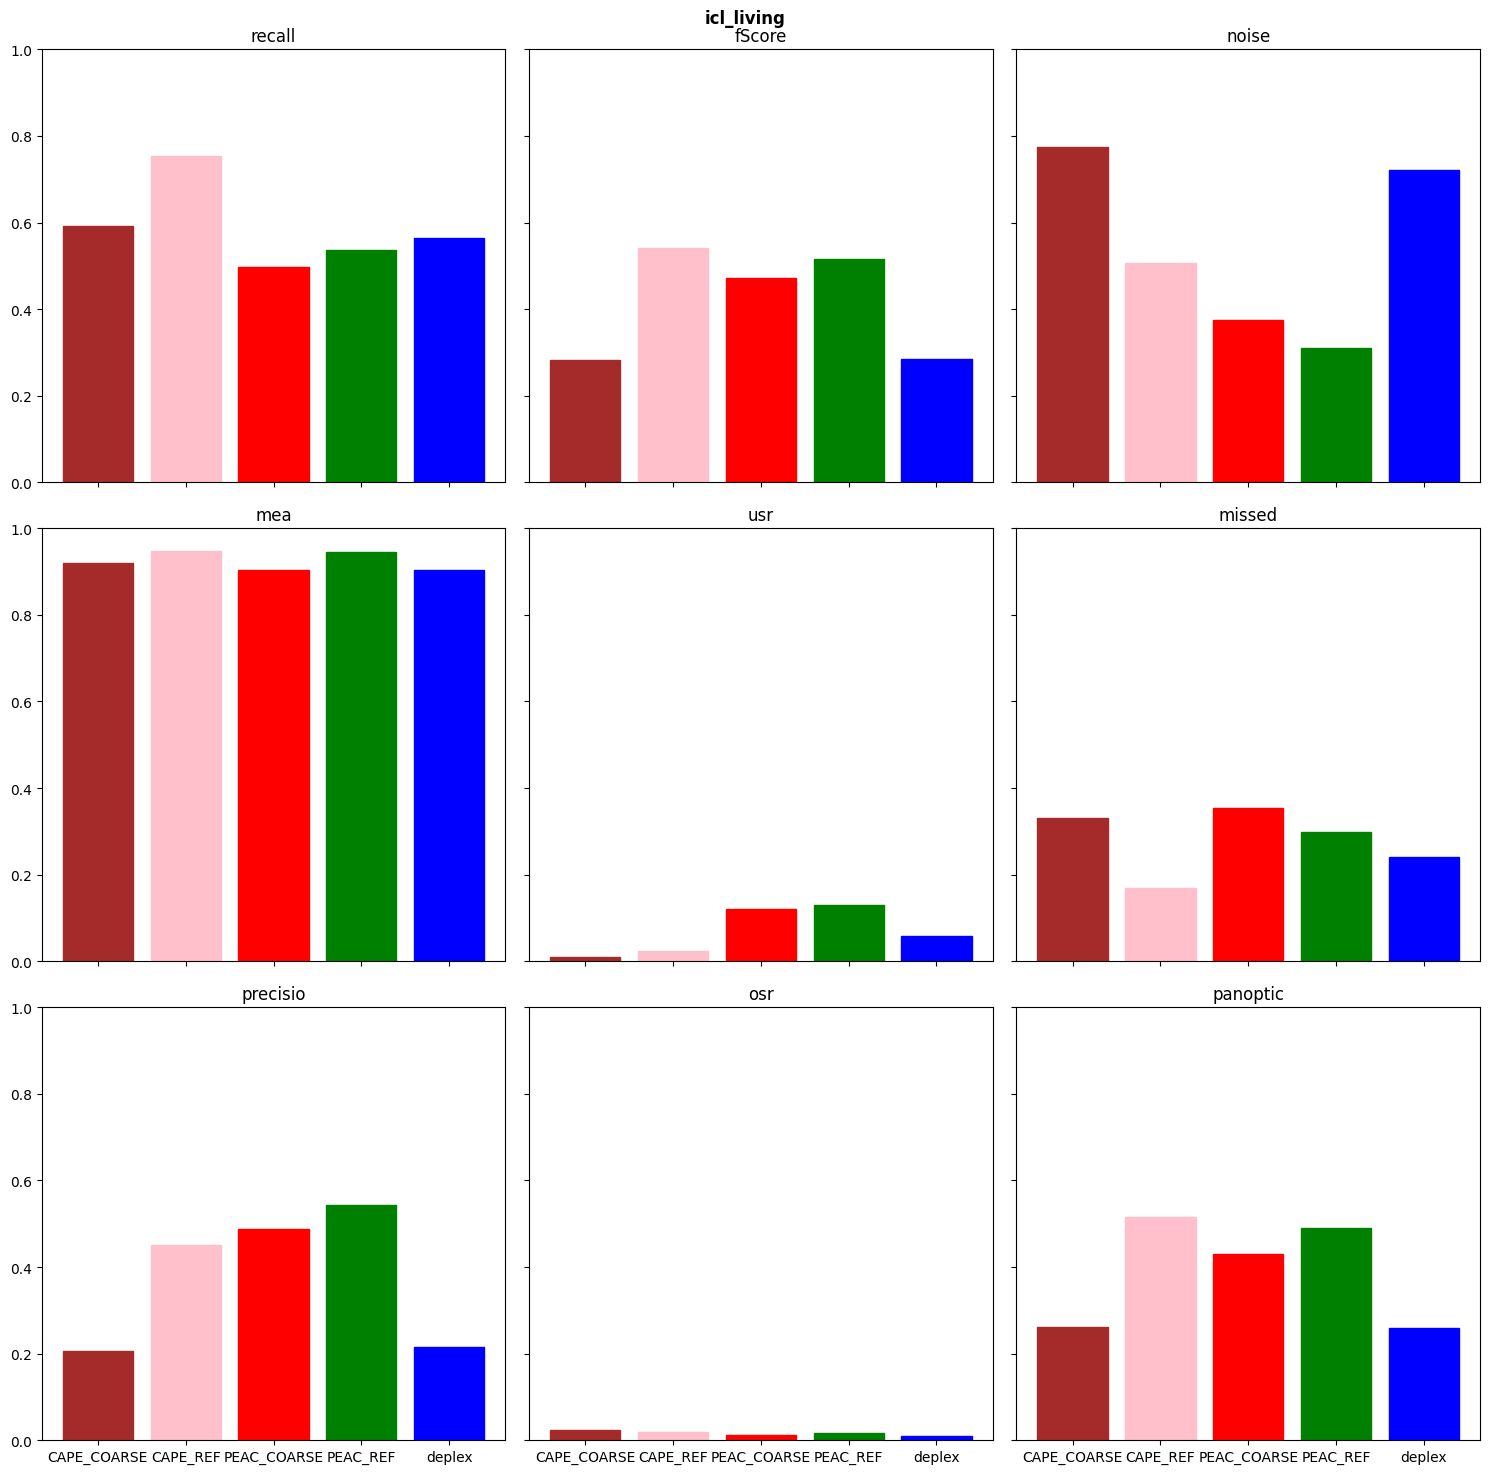

In [22]:
dataset_evaluation("icl_living", np.mean)